# Proof of Concept
******
## Overview
In this section, we will provide a demo of our system.  

For easier reference, the outline of the steps taken in this notebook is as follows:
##### Steps:
1. Import and Install Required Libraries
2. Loading Training and Testing Datasets
3. Data Exploration
4. Data Pre-processing
5. Setting Up the Model
6. Model Evaluation
7. Model Predictions

The first step for this Proof of Concept (POC) will be to import and install required libraries. This will allow us to perform important tasks across this POC such as data preprocessing, data visualisation, the creation of deep learning models and model evaluation. The first step also involves initialising any variables that we may need across multiple parts of the code. Next, we are required to load the data used to train and validate the predictions given by the model. Training datasets are categorised into two types, *unperturbed* and *perturbed*. The *perturbed* training dataset contains the images from the *unpertubed* dataset with digital makeup on. <br>
...
***************

## Step 1: Import and Install Required Libraries

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import math
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout 
import seaborn as sns
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
from ipykernel import kernelapp as app

In [2]:
epochs = 200
batch_size = 32
img_size = 224
labels = ['female', 'male']

******************
## Step 2: Load Training and Testing Datasets

In [3]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=list)

In [4]:
train = get_data('preprocessing/train_data')
val = get_data('preprocessing/val_data')
train_pert = get_data('preprocessing/makeup')

*********************
## Step 3: Data Exploration

In [5]:
def plot_dataset_ratio(l, count, data, femaleLabel, maleLabel):
    for i in data:
        if (i[1] == 0):
            l.append(femaleLabel)      
        else:
            l.append(maleLabel)
        count += 1

<AxesSubplot:>

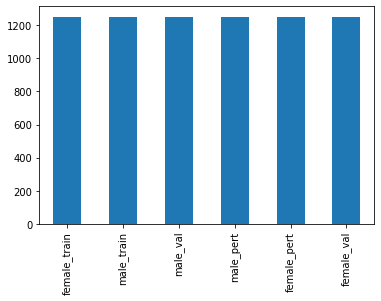

In [6]:
l = []
train_count = 0
val_count = 0
train_pert_count = 0

plot_dataset_ratio(l, train_count, train, "female_train", "male_train")
plot_dataset_ratio(l, train_pert_count, train_pert, "female_pert", "male_pert")
plot_dataset_ratio(l, val_count, val, "female_val", "male_val")

pd.value_counts(pd.Series(data=l)).plot.bar()

**********************
## Step 4: Data Pre-processing

In [7]:
x_train = []
y_train = []
x_train_pert = []
y_train_pert = []
x_val = []
y_val = []

# Unpertubed Dataset
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

# Perturbed Dataset
for feature, label in train_pert:
    x_train_pert.append(feature)
    y_train_pert.append(label)
x_train_pert = np.array(x_train_pert) / 255
x_train_pert.reshape(-1, img_size, img_size, 1)
y_train_pert = np.array(y_train_pert)

# Validation Dataset
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
x_val = np.array(x_val) / 255
x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

## Step 5: Setting Up the Model

The model that has been built is a Keras Model using the ```Sequential``` API. This will allow us to create models layer by layer and connect them in a sequantial order. The type of neural network that this model uses is a Convolutional Neural Network (CNN). CNN is a deep learning algorithm that consists of neurons with learnable weights and biases. Each artificial neuron accepts an input, performs matrix multiplication (between the input data and the weights) and outputs a non-linear transformation of the data.

The CNN architecture consists of the following distinct components:
1. Input Layer
2. Convolutional Blocks
3. Fully-Connected Layer

### <ins>Input Layer</ins>
The input layer contains the raw pixel values of images represented in a *3D*-matrix. The dimensions is in the order of *W* x *H* x *D*, where *W* and *H* represents the width and height of the image respectively, and *D* represents the color channels. In the case of this POC, we have images with a width of 224 pixels, a height of 224 pixels, and use three color channels (Red, Green, Blue channels).

### <ins>Convolutional Blocks</ins>
This model will have three convolutional blocks that are made up of:
1. <b>Convolutional Layers</b>  
2. <b>ReLu (Activation) Layer</b>
3. <b>Max Pooling Layer</b> 

The first component of the convolutional block are the <b>convolutional</b> (CONV) <b>layers</b>. CONV layers are the core building blocks of any CNN and is where a major part of computation happens. These layers use learnable filters that perform convolution operations that scans through an input and results in an output commonly known as feature maps (Amidi & Amidi, 2018). Using the Keras ```Sequential``` API, we can create and add CONV layers using Keras ```Conv2D```. The important hyperparameters for CONV layers that will be mentioned are: the <b>number of filters</b> used, <b>stride</b>, <b>kernel size</b>, <b>padding</b> and the type of <b>activation function</b>. 

1. The <b>number of filters</b> will affect the depth of the output. For example, to generate four different feature maps we would need four distinct filters, thus creating a depth of four. For our model, the number of filters will vary from filter to filter. This can be accomplished by updating the ```filters``` parameter of our ```Conv2D``` methods.

2. <b>Stride</b> refers to the number of rows and columns the kernel traverses per slide. Smaller strides generally lead to larger outputs, whereas larger strides lead to smaller outputs. For our model, we will be using the default setting by the ```Conv2D``` method, which is a stride of one (1).

3. <b>Kernel size</b> can be represented as an integer or a tuple with two integers that specifies the *2D* convolution window. For our model, it will use a kernel size with a width and height of 3px across all CONV layers. This is accomplished when we set the ```kernel_size``` parameter of our ```Conv2D``` methods to ```(3,3)```

4. There are several types of <b>padding</b>, including same padding, full padding and valid padding. For our model, it will use same padding. This is accomplished when we set the ```padding``` parameter of our ```Conv2D``` methods to ```same```. This will ensure that the output layer is the same size of the input layer.

5. Keras offers multiple types of layer ```activation``` functions, all of which have their own use cases, advantages and disadvantages. For our model, it will use the Rectified-Linear Unit (ReLu) activation function for the ```Conv2D``` and ```Dense``` methods within the convolutional block. This is accomplished when we set the ```activation``` parameter of these methods to ```relu```. 

As additional feature to the layers of our model, we will employ dropout regularisation to prevent our model from overfitting. Overfitting refers to a model that fits the training data too well, hence affecting the model's ability to predict given new and unseen data. Dropout regularisation is a technique that will randomly choose neurons to when training the model. By doing so, the activation of neurons becomes sparse, thus causing the model to improve in its ability to generalise.

The other two components of the convolutional blocks are the <b>ReLu activation layer</b> and <b>max pooling layer</b>. The ReLu activation layer uses a piecewise linear function that determines whether a node will output the given input (if positive) or output zero (otherwise). The max pooling layer, like the convolutional layer, filters across the input volumn and selects the pixel that has the greatest value to send to the output layer.

### <ins>Fully-Connected Layer </ins>
The purpose of the fully-connected (FC) layer is to perform class predictions. The input for this layer will be a flattened vector of nodes that was activated in the earlier part of the model process. To flatten a vector of nodes, we will use the ```Flatten()``` method at the beginning of the FC layer. This will turn *3D* feature maps into a *1D* input tensor. The FC layer will be constructed using ```Dense``` layers. As for the final output layer, it will use the ```softmax``` activation function which can be both used for binary and multi-class problems. This is accomplished by setting ```activation``` parameter in the final ```Dense``` layer to ```softmax```. Once the model is built, the model will then be compiled using the ```Adam``` optimizer with a learning rate of ```0.000001```, a ```SparseCategoricalCrossentropy``` loss and use ```accuracy``` for our performance ```metric```. 

In [8]:
def createModel():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(224,224,3)))
    
    # Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully-Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    opt = Adam(lr=0.000001)
    model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
    
    return model

In [ ]:
# Without Pertubations
# model = createModel()
# checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, # Saves checkpoints
#                              save_best_only=True, mode='min', save_freq='epoch')
# history = model.fit(x_train,y_train,epochs = epochs ,
#                     batch_size=batch_size,
#                     verbose=1,
#                     validation_data = (x_val, y_val), 
#                     callbacks = [checkpoint])
# # Store model history as a json 
# with open('history/model_history.json', 'w') as f:
#     json.dump(history.history, f)

In [ ]:
# With Pertubations
# model_pert = createModel()
# checkpoint_pert = ModelCheckpoint('model_best_weights_pert.h5', monitor='loss', verbose=1, # Saves checkpoints
#                              save_best_only=True, mode='min', save_freq='epoch')
# history_pert = model_pert.fit(x_train_pert,y_train_pert,epochs = epochs ,
#                     batch_size=batch_size,
#                     verbose=1,
#                     validation_data = (x_val, y_val), 
#                     callbacks = [checkpoint_pert])
# # Store model history as a json 
# with open('history/model_pert_history.json', 'w') as f:
#     json.dump(history_pert.history, f)

To load in a pre-trained model and to avoid repetitive computation, we will the following code and comment out code that performs model training:

In [10]:
# Load model trained on unperturbed data
model = tf.keras.models.load_model('model_best_weights.h5')

# Load model trained on perturbed data
model_pert = tf.keras.models.load_model('model_best_weights_pert.h5') 

Epoch 1/200
79/79 [==============================] - 11s 86ms/step - loss: 0.6923 - accuracy: 0.5072 - val_loss: 0.6910 - val_accuracy: 0.5916

Epoch 00001: loss improved from inf to 0.69239, saving model to model_best_weights.h5
Epoch 2/200
79/79 [==============================] - 6s 70ms/step - loss: 0.6876 - accuracy: 0.5514 - val_loss: 0.6889 - val_accuracy: 0.5852

Epoch 00002: loss improved from 0.69239 to 0.68603, saving model to model_best_weights.h5
Epoch 3/200
79/79 [==============================] - 5s 67ms/step - loss: 0.6843 - accuracy: 0.5560 - val_loss: 0.6869 - val_accuracy: 0.5832

Epoch 00003: loss improved from 0.68603 to 0.68182, saving model to model_best_weights.h5
Epoch 4/200
79/79 [==============================] - 5s 67ms/step - loss: 0.6759 - accuracy: 0.6012 - val_loss: 0.6851 - val_accuracy: 0.5948

Epoch 00004: loss improved from 0.68182 to 0.67716, saving model to model_best_weights.h5
Epoch 5/200
79/79 [==============================] - 5s 67ms/step - los

********
## Step 6: Model Evaluation and Predictions

Discussion points:
- Compare Accuracy and Loss
- Compare Confusion Matrices
- Why the precision, recall and f1-score are similar when the data is unpertubated.
- Why the recall is so consistently high when the data is pertubated.


In [387]:
ext = [[72.0, 97.04347826086959], [188.4521739130435, 97.04347826086956], [304.904347826087, 97.04347826086956], [421.35652173913047, 97.04347826086962]]
target_names = ['Female (Class 0)','Male (Class 1)']
test_datagen = ImageDataGenerator(rescale = 1./255)
val_gen = test_datagen.flow_from_directory("preprocessing/val_data",
                                                            target_size=(224, 224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

# Unperturbed Data
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
### Generates confusion matrix
Y_pred = model.predict(val_gen, 2500 // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
### Unperturbed history
with open("history/model_history.json") as json_file:
    history = json.load(json_file)

# Perturbed Data
acc_pert = history_pert['accuracy']
val_acc_pert = history_pert['val_accuracy']
loss_pert = history_pert['loss']
val_loss_pert = history_pert['val_loss']
### Generates confusion matrix
Y_pred_pert = model_pert.predict(val_gen, 2500 // batch_size)
y_pred_pert = np.argmax(Y_pred_pert, axis=1)
cf_matrix_pert = confusion_matrix(validation_generator.classes, y_pred_pert)
### Perturbed history
with open("history/model_pert_history.json") as json_pert_file:
    history_pert = json.load(json_pert_file)

        
def gen_acc(matrix, prnt=False):
    true_neg = matrix[0][0]
    true_pos = matrix[1][1]
    acc = (true_neg+true_pos)/total
    if prnt:
        print("Overall Categorical Accuracy: {:.2f}%".format(acc*100))
    return acc
    
def gen_gbi(cf_matrix, cf_matrix_pert):
    total = np.sum(cf_matrix)    # Total is the same for unperturbed data

    # Unperturbed Data
    acc = gen_acc(cf_matrix)

    # Perturbed Data
    acc_pert = gen_acc(cf_matrix_pert)

    gender_bias_index = "{0:.2%}".format(acc - acc_pert)
    return "Gender Bias Index: " + gender_bias_index

def plot_train_val_acc_loss():
    epochs_range = range(epochs)

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(19,10)) 
    fig.suptitle("Unperturbed vs Perturbed", fontsize='x-large')
    fig.subplots_adjust(top=0.85)


    # Model Train on Unperturbed Data
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', c="#f21170")
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', c="#ff8474")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, loss, label='Training Loss', c="#f21170")
    plt.plot(epochs_range, val_loss, label='Validation Loss', c="#ff8474")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


    # Model Train on Perturbed Data
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, acc_pert, label='Training Accuracy', c="#9f5f80")
    plt.plot(epochs_range, val_acc_pert, label='Validation Accuracy', c="#583d72")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, loss_pert, label='Training Loss', c="#9f5f80")
    plt.plot(epochs_range, val_loss_pert, label='Validation Loss', c="#583d72")
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )
    width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
    right_center = inv.transform( (width_right, 1) )
    plt.figtext(left_center[0],0.9,"Model Trained on Unperturbed Data", va="center", ha="center", size=20)
    plt.figtext(right_center[0],0.9,"Model Trained on Perturbed Data", va="center", ha="center", size=20)

    plt.show()
    
def gen_cm():
    f,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,4))

    # Unperturbed Data
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    # Perturbed Data
    group_counts_pert = ["{0:0.0f}".format(value) for value in
                    cf_matrix_pert.flatten()]
    group_percentages_pert = ["{0:.2%}".format(value) for value in
                         cf_matrix_pert.flatten()/np.sum(cf_matrix_pert)]

    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm_pert = pd.DataFrame(cf_matrix_pert, range(2), range(2))

    labels = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]).reshape(2,2)
    labels_pert = np.asarray([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts_pert,group_percentages_pert)]).reshape(2,2)
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )
    width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
    right_center = inv.transform( (width_right, 1) )
    plt.figtext(left_center[0],0.95,"Model Trained on Unperturbed Data", va="center", ha="center", size=15)
    plt.figtext(right_center[0],0.95,"Model Trained on Perturbed Data", va="center", ha="center", size=15)

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=labels, annot_kws={"size": 15}, cmap='YlOrBr', fmt='', ax=ax[0])
    sns.heatmap(df_cm_pert, annot=labels_pert, annot_kws={"size": 15}, cmap='Blues', fmt='', ax=ax[1])
    plt.show()
    
def gen_cr():
    print("---------------------------------------------------------")
    print("Model trained on Unperturbed Data")
    print("---------------------------------------------------------")
    print(classification_report(val_gen.classes, y_pred, target_names=target_names, zero_division=1))
    print("---------------------------------------------------------")

    print("Model trained on Perturbed Data")
    print("---------------------------------------------------------")
    print(classification_report(val_gen.classes, y_pred_pert, target_names=target_names, zero_division=1))

Found 2500 images belonging to 2 classes.


### Accuracy and Loss

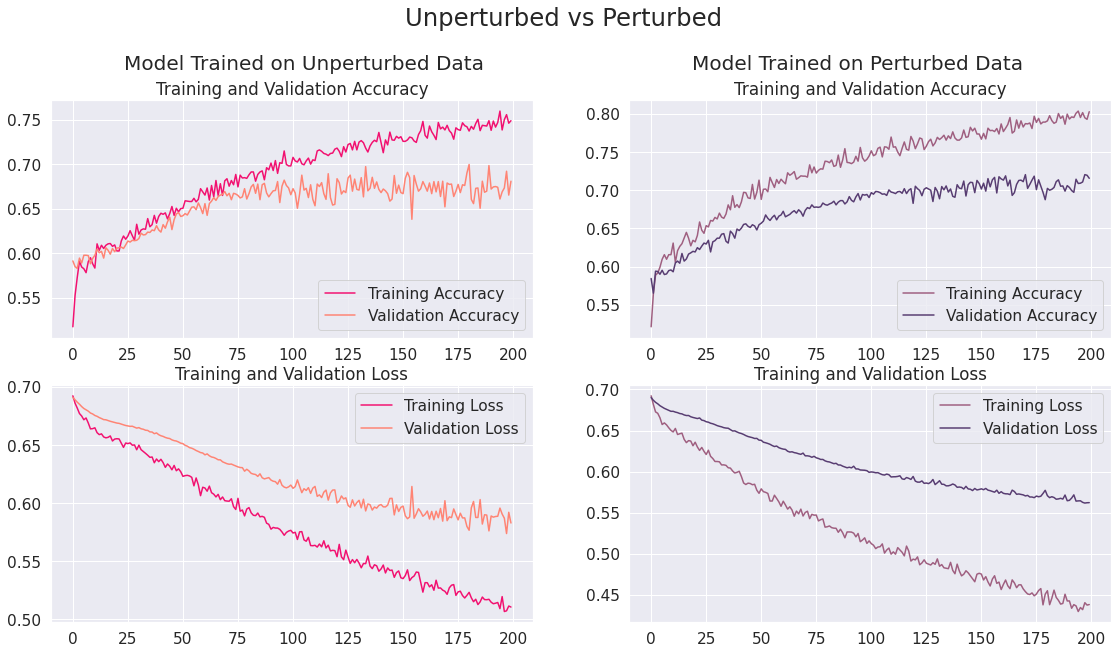

In [354]:
plot_train_val_acc_loss()

#### Comparing Accuracies

In [339]:
# Model trained on unperturbated data
gen_acc(cf_matrix)

Overall Categorical Accuracy: 51.56%


In [340]:
# Model trained on perturbated data
gen_acc(cf_matrix_pert)

Overall Categorical Accuracy: 50.36%


### Confusion Matrix

- Definition of TN, FN, TP, FP

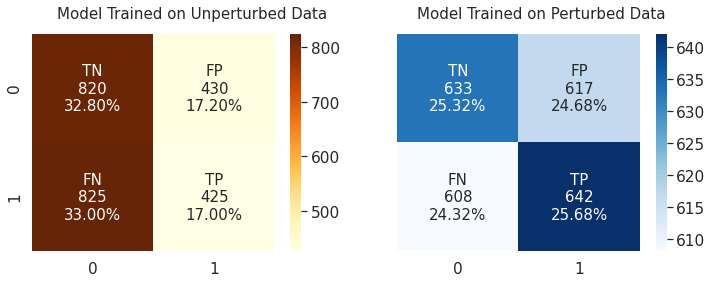

In [384]:
gen_cm()

### Classification Report

In [388]:
gen_cr()

---------------------------------------------------------
Model trained on Unperturbed Data
---------------------------------------------------------
                  precision    recall  f1-score   support

Female (Class 0)       0.50      0.66      0.57      1250
  Male (Class 1)       0.50      0.34      0.41      1250

        accuracy                           0.50      2500
       macro avg       0.50      0.50      0.49      2500
    weighted avg       0.50      0.50      0.49      2500

---------------------------------------------------------
Model trained on Perturbed Data
---------------------------------------------------------
                  precision    recall  f1-score   support

Female (Class 0)       0.51      0.50      0.51      1250
  Male (Class 1)       0.51      0.51      0.51      1250

        accuracy                           0.51      2500
       macro avg       0.51      0.51      0.51      2500
    weighted avg       0.51      0.51      0.51      2500



#### Precision

#### Recall

#### f1-score

### Gender Bias Index

In [359]:
gen_gbi(cf_matrix, cf_matrix_pert)

'Gender Bias Index: -1.92%'

********
## Step 7: Making Predictions

Through analysis of the images below, it seems that when the data is pertubated with make up on, it is more likely that the model will predict that the subject is a female. 

Speculations:
- Adding some make up to classified male faces may improve gender biasness in AI
- Removing make up features from females may improve gender biasness in AI

### Without Pertubation

In [342]:
def predictImage(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

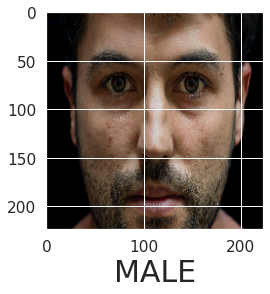

In [343]:
predictImage("random.jpeg")

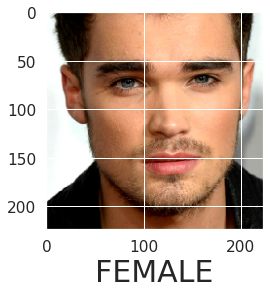

In [344]:
predictImage("celeb.jpg")

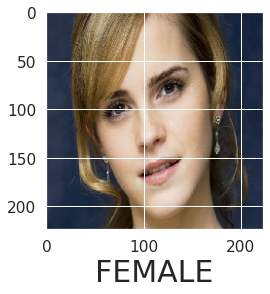

In [345]:
predictImage("emma.jpg")

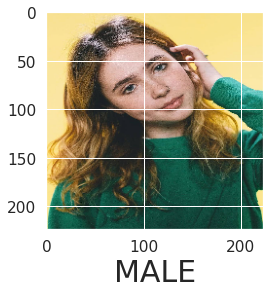

In [346]:
predictImage("clairo.jpeg")

### With Pertubation

In [347]:
def predictImagePert(filename):
    img = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr = input_arr.astype('float32') / 255.  # This is VERY important
    predictions = model_pert.predict(input_arr)
    val = np.argmax(predictions, axis=-1)
    
    img1 = image.load_img(filename,target_size=(img_size,img_size))
    plt.imshow(img1)
    if val == 1:
        plt.xlabel("MALE",fontsize=30)
    elif val == 0:
        plt.xlabel("FEMALE",fontsize=30)

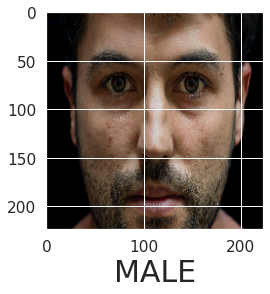

In [348]:
predictImagePert("random.jpeg")

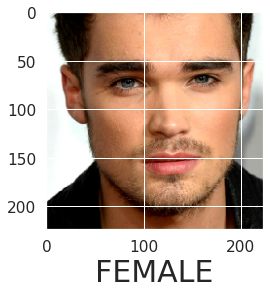

In [349]:
predictImagePert("celeb.jpg")

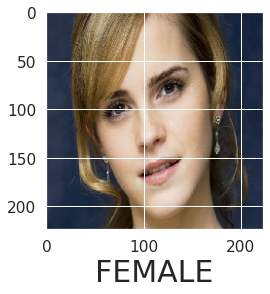

In [350]:
predictImagePert("emma.jpg")

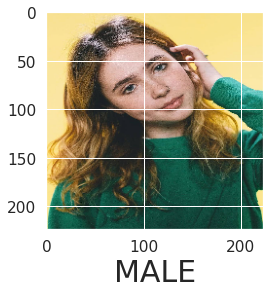

In [351]:
predictImagePert("clairo.jpeg")

## References
- https://developer.nvidia.com/blog/deep-learning-nutshell-core-concepts/
- https://www.tensorflow.org/tutorials/keras/save_and_load
- https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
- https://cs231n.github.io/convolutional-networks/https://cs231n.github.io/convolutional-networks/
- https://deeplizard.com/learn/video/daovGOlMbT4
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
- https://www.ibm.com/cloud/learn/convolutional-neural-networks
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf